In [5]:
import nltk
import torch
import torch.nn as nn
from nltk.tokenize import RegexpTokenizer
from torch.utils.data import Dataset, DataLoader
from WordDataset import WordDataset
from Translator import Translator
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

device = torch.device('cuda')
torch.cuda.empty_cache()

In [6]:
source = []
target = []

with open('rus.txt') as f:
    for line in f:
        t, s = line.split('\t')[:2]
        target.append(s.lower())
        source.append(t.lower())

tokenizer = RegexpTokenizer(r'\w+')

target_bag_of_words = []
source_bag_of_words = []

target_sentences = []
source_sentences = []

for i in range(len(target)):
    t_sent = target[i]
    s_sent = source[i]
    t_tokens = tokenizer.tokenize(t_sent)
    s_tokens = tokenizer.tokenize(s_sent)
    
    target_bag_of_words.extend(t_tokens)
    source_bag_of_words.extend(s_tokens)

    target_sentences.append(t_tokens)
    source_sentences.append(s_tokens)
    

special_symbols = ['<SOS>', '<EOS>', '<PAD>', '<UNK>']

target_bag_of_words.extend(special_symbols)
source_bag_of_words.extend(special_symbols)
target_bag_of_words = set(target_bag_of_words)
source_bag_of_words = set(source_bag_of_words)

source_word2ind = {word: ind for ind, word in enumerate(source_bag_of_words)}
target_word2ind = {word: ind for ind, word in enumerate(target_bag_of_words)}
source_ind2word = {ind: word for ind, word in enumerate(source_bag_of_words)}
target_ind2word = {ind: word for ind, word in enumerate(target_bag_of_words)}


In [7]:
del target_bag_of_words
del source_bag_of_words
del special_symbols

In [8]:
max_len = max(max([len(sentence) for sentence in target_sentences]), max([len(sentence) for sentence in source_sentences]))

In [9]:
dataset = WordDataset(source_sentences, target_sentences, source_word2ind, target_word2ind, max_len = 2)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

In [10]:
def train_model(model, criterion, optimizer, dataloader, num_epoch):
    model.train()
    losses = []
    for epoch in range(1, num_epoch+1):
        print(f'epoch:{epoch}')
        for source, target in tqdm(dataloader):
            optimizer.zero_grad()
            
            target_input = target[:, :-1].to(device)
            target_output = target[:, 1:].to(device).flatten(start_dim = 0, end_dim = 1)

            outp = model(source.to(device), target_input).squeeze()
            outp = outp.flatten(start_dim = 0, end_dim = 1)

            
            loss = criterion(outp.to(device), target_output)
            loss.backward()
            optimizer.step()

            
            losses.append(loss.item())
    
    return losses
            

In [11]:
print(len(target_word2ind))

53270


In [12]:
model = Translator(len(source_word2ind), len(target_word2ind), 300, dropout_prob=0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
# lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=30)

In [13]:
losses = train_model(model, criterion, optimizer, dataloader, 1)

epoch:1


100%|██████████| 1817/1817 [01:10<00:00, 25.89it/s]


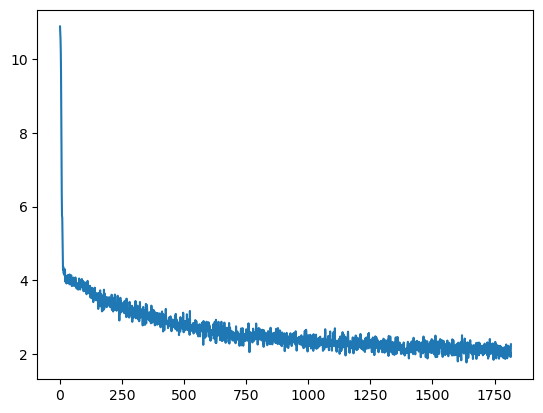

In [14]:
plt.plot(losses)
plt.show()

In [15]:
import torch.nn.functional as F

def translate_sentence(model, sentence, tokenizer, device='cuda', max_length=5, temperature = 1):
    model.eval()
    
    source_tokens = tokenizer.tokenize(sentence)
    # Добавляем размерность батча
    source_tensor = torch.LongTensor([[source_word2ind['<SOS>']]+[source_word2ind[word] for word in source_tokens]+[source_word2ind['<EOS>']]]).to(device)
    # source_tensor = torch.LongTensor([[source_word2ind[word] for word in source_tokens]]).to(device)
    target_tokens = [target_word2ind['<SOS>']]
    
    with torch.no_grad():
        source_embeddings = model.source_embeddings(source_tensor)  
        _, encoded_hidden = model.encoder(source_embeddings) 
        
        for _ in range(max_length):
            target_tensor = torch.LongTensor([target_tokens]).to(device) 
            
            target_embeddings = model.target_embeddings(target_tensor)  
            
            output, _ = model.decoder(target_embeddings, encoded_hidden)
            output = model.non_lin(model.linear(model.non_lin(output)))
            logits = model.projection(output)/temperature
            
            probabilities = F.softmax(logits[0, -1], dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1).item()
            target_tokens.append(next_token)
            
            if next_token == target_word2ind['<EOS>']:
                break
    
    translated_tokens = target_tokens[1:-1] 
    translated_sentence = " ".join(target_ind2word[idx] for idx in translated_tokens)
    
    return translated_sentence

In [33]:
translate_sentence(model, 'what',  tokenizer, max_length = 3, temperature = 0.001)

'это моя'